<a href="https://colab.research.google.com/github/HusseinEid101/LLama-3-LoRA-finetuned-Python-bot/blob/main/Llama_3_LoRA_finetuned_Python_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Large language model fine-tuned using low rank adapter to generate efficient python code, a python chatbot**

**Project by Hussein Eid**

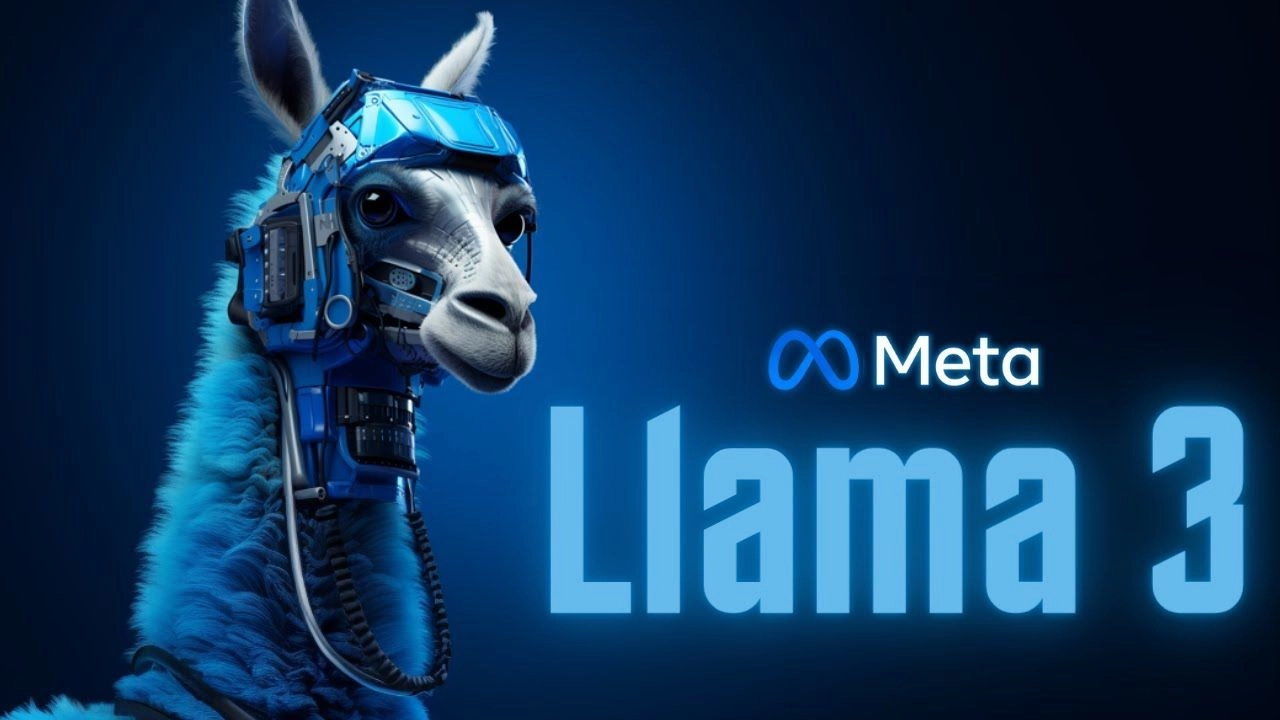

## Importing necessary dependencies

In [ ]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes

## Defining the model and tokenizer
`llama 3` is our choice

In [ ]:
from unsloth import FastLanguageModel
import torch
import os

hf_token = os.environ.get("HF_TOKEN")

max_seq_length = 2048 # Auto-support RoPE Scaling is provided internally in unsloth
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "meta-llama/Meta-Llama-3-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    token = hf_token,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


Unsloth: You passed in `meta-llama/Meta-Llama-3-8B` and `load_in_4bit = True`.
We shall load `unsloth/llama-3-8b-bnb-4bit` for 4x faster loading.


config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Adding LoRA adapters so we only need to update 1 to 10% of all parameters

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


<a name="Data"></a>
### Data Preparation
Using `ChatML` format for conversation style finetunes. I used [python generation conversations](https://huggingface.co/datasets/ajibawa-2023/Python-Code-23k-ShareGPT) in ShareGPT style. ChatML renders multi turn conversations like below:

```
<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
What's the capital of France?<|im_end|>
<|im_start|>assistant
Paris.
```

Using `get_chat_template` function to get the correct chat template.

Normally one has to train `<|im_start|>` and `<|im_end|>`. We instead map `<|im_end|>` to be the EOS token, and leave `<|im_start|>` as is. This requires no additional training of additional tokens.

**Note**  ShareGPT uses `{"from": "human", "value" : "Hi"}` and not `{"role": "user", "content" : "Hi"}`, so i used `mapping` to map it.

In [ ]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "chatml",
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
    map_eos_token = True, # Maps <|im_end|> to </s> instead
)

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("ajibawa-2023/Python-Code-23k-ShareGPT", split = "train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

Unsloth: Will map <|im_end|> to EOS = <|end_of_text|>.


Generating train split:   0%|          | 0/22608 [00:00<?, ? examples/s]

Map:   0%|          | 0/22608 [00:00<?, ? examples/s]

Let's see how the `ChatML` format works by printing a random sample, say the 10th element

In [ ]:
dataset[10]["conversations"]

[{'from': 'human',
  'value': 'Modify the code to perform the mathematical expression "x to the power of y" while also ensuring that the value of x is between 1 and 10, and the value of y is between 0 and 5. Additionally, the code should handle any potential errors or edge cases that may arise during the calculation. The code should also check for invalid inputs such as non-numeric values for x and y, and display appropriate error messages. \n\nHowever, the program should now be able to handle extremely large numbers efficiently and accurately, even when x is a decimal number. The program should use a custom algorithm to calculate the result, rather than relying on any built-in math functions. The program should also provide the result in scientific notation if it exceeds a certain threshold, which should be dynamically determined based on the input values.'},
 {'from': 'gpt',
  'value': 'Here\'s an example of how the code can be modified to meet the given requirements:\n\n```python\ni

#### And here is the same sample after formatting

In [ ]:
print(dataset[10]["text"])

<|im_start|>user
Modify the code to perform the mathematical expression "x to the power of y" while also ensuring that the value of x is between 1 and 10, and the value of y is between 0 and 5. Additionally, the code should handle any potential errors or edge cases that may arise during the calculation. The code should also check for invalid inputs such as non-numeric values for x and y, and display appropriate error messages. 

However, the program should now be able to handle extremely large numbers efficiently and accurately, even when x is a decimal number. The program should use a custom algorithm to calculate the result, rather than relying on any built-in math functions. The program should also provide the result in scientific notation if it exceeds a certain threshold, which should be dynamically determined based on the input values.<|im_end|>
<|im_start|>assistant
Here's an example of how the code can be modified to meet the given requirements:

```python
import math

def powe

#### The unsloth `template` and end-of-sequence `EOS` are provided here

In [22]:
unsloth_template = \
    "{{ bos_token }}"\
    "{{ 'You are a helpful assistant to the user\n' }}"\
    "{% endif %}"\
    "{% for message in messages %}"\
        "{% if message['role'] == 'user' %}"\
            "{{ '>>> User: ' + message['content'] + '\n' }}"\
        "{% elif message['role'] == 'assistant' %}"\
            "{{ '>>> Assistant: ' + message['content'] + eos_token + '\n' }}"\
        "{% endif %}"\
    "{% endfor %}"\
    "{% if add_generation_prompt %}"\
        "{{ '>>> Assistant: ' }}"\
    "{% endif %}"
unsloth_eos_token = "eos_token"

if False:
    tokenizer = get_chat_template(
        tokenizer,
        chat_template = (unsloth_template, unsloth_eos_token,), # template and EOS token
        mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
        map_eos_token = True, # Maps <|im_end|> to </s> instead
    )

<a name="Train"></a>
### Training the model
Now let's use Huggingface TRL's `SFTTrainer`, the training arguments and hyperparameters are provided from their documentatin

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/22608 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
5.594 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 22,608 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,0.883800
2,0.882300
3,1.068900
4,0.769500
5,0.894500
6,0.751300
7,0.660200
8,0.571000
9,0.704400
10,0.606700


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

841.1018 seconds used for training.
14.02 minutes used for training.
Peak reserved memory = 9.531 GB.
Peak reserved memory for training = 3.937 GB.
Peak reserved memory % of max memory = 64.626 %.
Peak reserved memory for training % of max memory = 26.695 %.


<a name="Inference"></a>
### Inference
Let's test the model! Since I was using `ChatML`, I used `apply_chat_template` with `add_generation_prompt` set to `True` for inference.

In [ ]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "chatml",
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
    map_eos_token = True, # Maps <|im_end|> to </s> instead
)

FastLanguageModel.for_inference(model) # Enable native 2x faster inference
messages = [
    {"from": "human", "value": "Generate a python code that plots the mandelbrot set"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")
outputs = model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

Unsloth: Will map <|im_end|> to EOS = <|im_end|>.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


['<|im_start|>user\nGenerate a python code that plots the mandelbrot set<|im_end|>\n<|im_start|>assistant\nHere is a python code that plots the mandelbrot set:\n\n```python\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n# Define the complex plane\nx_range = np.linspace(-2.0, 1.0, 1000)\ny_range = np.linspace(-1.0, ']

Using `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time

Just like ChatGPT

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
messages = [
    {"from": "human", "value": "Generate a python code that plots the mandelbrot set"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128, use_cache = True)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|im_start|>user
Generate a python code that plots the mandelbrot set<|im_end|>
<|im_start|>assistant
Here is a python code that plots the mandelbrot set using the numpy library:

```python
import numpy as np
import matplotlib.pyplot as plt

def mandelbrot(c):
    z = 0
    n = 0
    while abs(z) < 2 and n < 100:
        z = z*z + c
        n += 1
    if n == 100:
        return 0
    else:
        return n

width = 500
height = 500
x_min = -2
x_max = 1
y_min = -1.5



<a name="Save"></a>
### Saving the finetuned model
To save the final model, I used Huggingface's `push_to_hub` to save the model on the hub to use later with the Huggingface chatbot space.

In [ ]:
# Merge to 16bit
model.push_to_hub_merged("HusseinEid/llama-3-finetuned-pythonBOT", tokenizer, save_method = "merged_16bit", token = hf_token)

Unsloth: You are pushing to hub, but you passed your HF username = HusseinEid.
We shall truncate HusseinEid/llama-3-finetuned-pythonBOT to llama-3-finetuned-pythonBOT


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 4.59 out of 12.67 RAM for saving.


100%|██████████| 32/32 [05:32<00:00, 10.38s/it]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving model... This might take 5 minutes for Llama-7b...
Unsloth: Saving llama-3-finetuned-pythonBOT/pytorch_model-00001-of-00004.bin...
Unsloth: Saving llama-3-finetuned-pythonBOT/pytorch_model-00002-of-00004.bin...
Unsloth: Saving llama-3-finetuned-pythonBOT/pytorch_model-00003-of-00004.bin...
Unsloth: Saving llama-3-finetuned-pythonBOT/pytorch_model-00004-of-00004.bin...


README.md:   0%|          | 0.00/577 [00:00<?, ?B/s]

pytorch_model-00002-of-00004.bin:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

pytorch_model-00004-of-00004.bin:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

pytorch_model-00003-of-00004.bin:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

pytorch_model-00001-of-00004.bin:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Done.
Saved merged model to https://huggingface.co/HusseinEid/llama-3-finetuned-pythonBOT
